## Cell 1: Import Libraries and Setup



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style and suppress warnings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## Cell 2: Load and Initial Data Inspection



In [4]:
# Load the datasets
data = pd.read_csv('/kaggle/input/rna-seq-q/TCGA-PANCAN-HiSeq-801x20531/TCGA-PANCAN-HiSeq-801x20531/data.csv', index_col=0)
labels = pd.read_csv('/kaggle/input/rna-seq-q/TCGA-PANCAN-HiSeq-801x20531/TCGA-PANCAN-HiSeq-801x20531/labels.csv', index_col=0)

print("=== DATASET OVERVIEW ===")
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"\nData columns: {data.columns.tolist()[:10]} ... (showing first 10)")
print(f"Labels columns: {labels.columns.tolist()}")

# Check if indices match
print(f"\nIndex alignment check:")
print(f"Data index matches labels index: {data.index.equals(labels.index)}")
print(f"Common samples: {len(set(data.index) & set(labels.index))}")

# Basic info
print(f"\n=== DATA TYPES ===")
print(f"Data dtypes: {data.dtypes.value_counts()}")
print(f"Labels dtypes: {labels.dtypes}")

# Check for missing values
print(f"\n=== MISSING VALUES ===")
print(f"Missing values in data: {data.isnull().sum().sum()}")
print(f"Missing values in labels: {labels.isnull().sum().sum()}")

=== DATASET OVERVIEW ===
Data shape: (801, 20531)
Labels shape: (801, 1)

Data columns: ['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5', 'gene_6', 'gene_7', 'gene_8', 'gene_9'] ... (showing first 10)
Labels columns: ['Class']

Index alignment check:
Data index matches labels index: True
Common samples: 801

=== DATA TYPES ===
Data dtypes: float64    20531
Name: count, dtype: int64
Labels dtypes: Class    object
dtype: object

=== MISSING VALUES ===
Missing values in data: 0
Missing values in labels: 0


## Cell 3: Explore Target Classes



=== TARGET CLASS ANALYSIS ===
Class distribution:
Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64

Class percentages:
Class
BRCA    37.45
KIRC    18.23
LUAD    17.60
PRAD    16.98
COAD     9.74
Name: count, dtype: float64


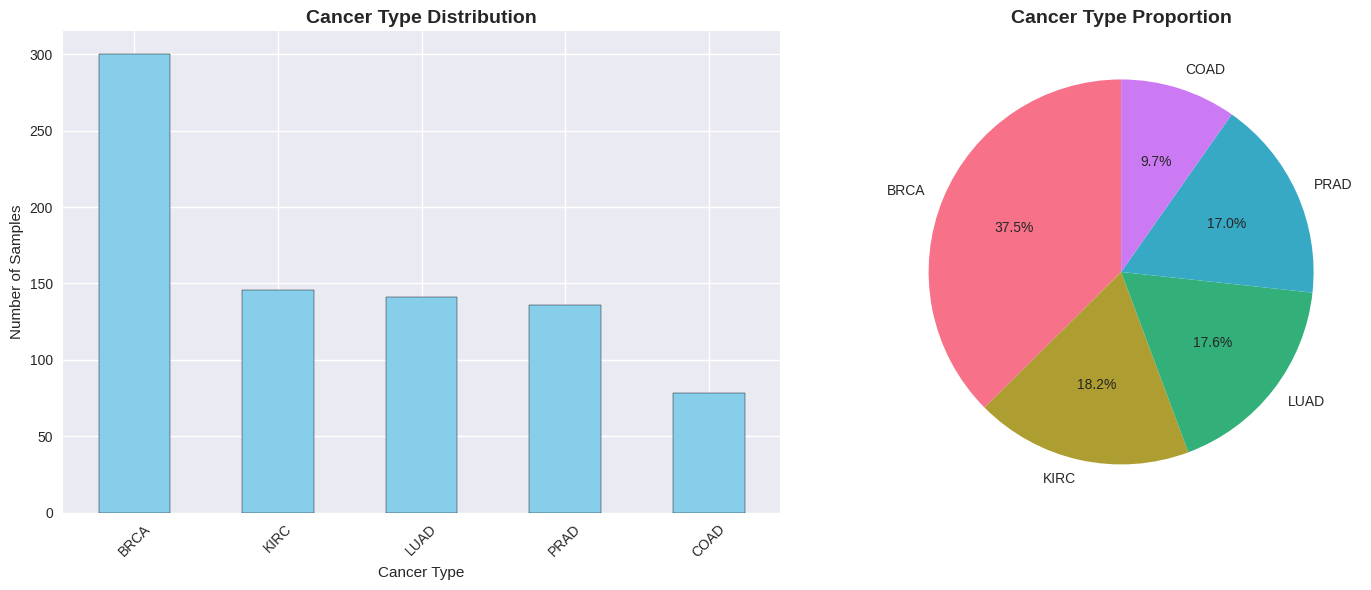


=== CANCER TYPE DESCRIPTIONS ===
BRCA: Breast Invasive Carcinoma (300 samples)
KIRC: Kidney Renal Clear Cell Carcinoma (146 samples)
COAD: Colon Adenocarcinoma (78 samples)
LUAD: Lung Adenocarcinoma (141 samples)
PRAD: Prostate Adenocarcinoma (136 samples)


In [5]:
# Analyze target classes
print("=== TARGET CLASS ANALYSIS ===")
class_counts = labels['Class'].value_counts()
print(f"Class distribution:\n{class_counts}")
print(f"\nClass percentages:")
print(f"{(class_counts / len(labels) * 100).round(2)}")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
class_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Cancer Type Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cancer Type')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette("husl", len(class_counts)))
ax2.set_title('Cancer Type Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Cancer type descriptions
cancer_descriptions = {
    'BRCA': 'Breast Invasive Carcinoma',
    'KIRC': 'Kidney Renal Clear Cell Carcinoma', 
    'COAD': 'Colon Adenocarcinoma',
    'LUAD': 'Lung Adenocarcinoma',
    'PRAD': 'Prostate Adenocarcinoma'
}

print(f"\n=== CANCER TYPE DESCRIPTIONS ===")
for code, description in cancer_descriptions.items():
    count = class_counts.get(code, 0)
    print(f"{code}: {description} ({count} samples)")

## Cell 4: Gene Expression Data Analysis

In [6]:
# Analyze gene expression characteristics
print("=== GENE EXPRESSION ANALYSIS ===")

# Basic statistics
print(f"Number of genes: {data.shape[1]}")
print(f"Expression value range: [{data.values.min():.3f}, {data.values.max():.3f}]")
print(f"Mean expression across all genes: {data.values.mean():.3f}")
print(f"Standard deviation: {data.values.std():.3f}")

# Check for zero values (common in RNA-seq)
zero_counts = (data == 0).sum()
print(f"\nZero expression analysis:")
print(f"Total zero values: {(data == 0).sum().sum():,}")
print(f"Percentage of zero values: {((data == 0).sum().sum() / data.size * 100):.2f}%")

# Genes with high zero counts
high_zero_genes = zero_counts[zero_counts > len(data) * 0.8]  # >80% zeros
print(f"Genes with >80% zero values: {len(high_zero_genes)}")

# Sample-wise statistics
sample_stats = pd.DataFrame({
    'total_expression': data.sum(axis=1),
    'mean_expression': data.mean(axis=1),
    'median_expression': data.median(axis=1),
    'zero_count': (data == 0).sum(axis=1),
    'zero_percentage': (data == 0).sum(axis=1) / data.shape[1] * 100
})

print(f"\n=== SAMPLE-WISE STATISTICS ===")
print(sample_stats.describe())

=== GENE EXPRESSION ANALYSIS ===
Number of genes: 20531
Expression value range: [0.000, 20.779]
Mean expression across all genes: 6.443
Standard deviation: 4.058

Zero expression analysis:
Total zero values: 2,338,124
Percentage of zero values: 14.22%
Genes with >80% zero values: 1742

=== SAMPLE-WISE STATISTICS ===
       total_expression  mean_expression  median_expression   zero_count  \
count        801.000000       801.000000         801.000000   801.000000   
mean      132287.849455         6.443322           7.597195  2919.006242   
std         3185.403272         0.155151           0.193935   328.769134   
min       120970.343074         5.892082           6.839733  1622.000000   
25%       130191.842275         6.341232           7.481420  2704.000000   
50%       132618.290334         6.459417           7.620014  2894.000000   
75%       134472.868407         6.549748           7.741150  3106.000000   
max       145246.945578         7.074519           8.195047  4592.000000  

## Cell 5: Distribution Analysis and Visualization



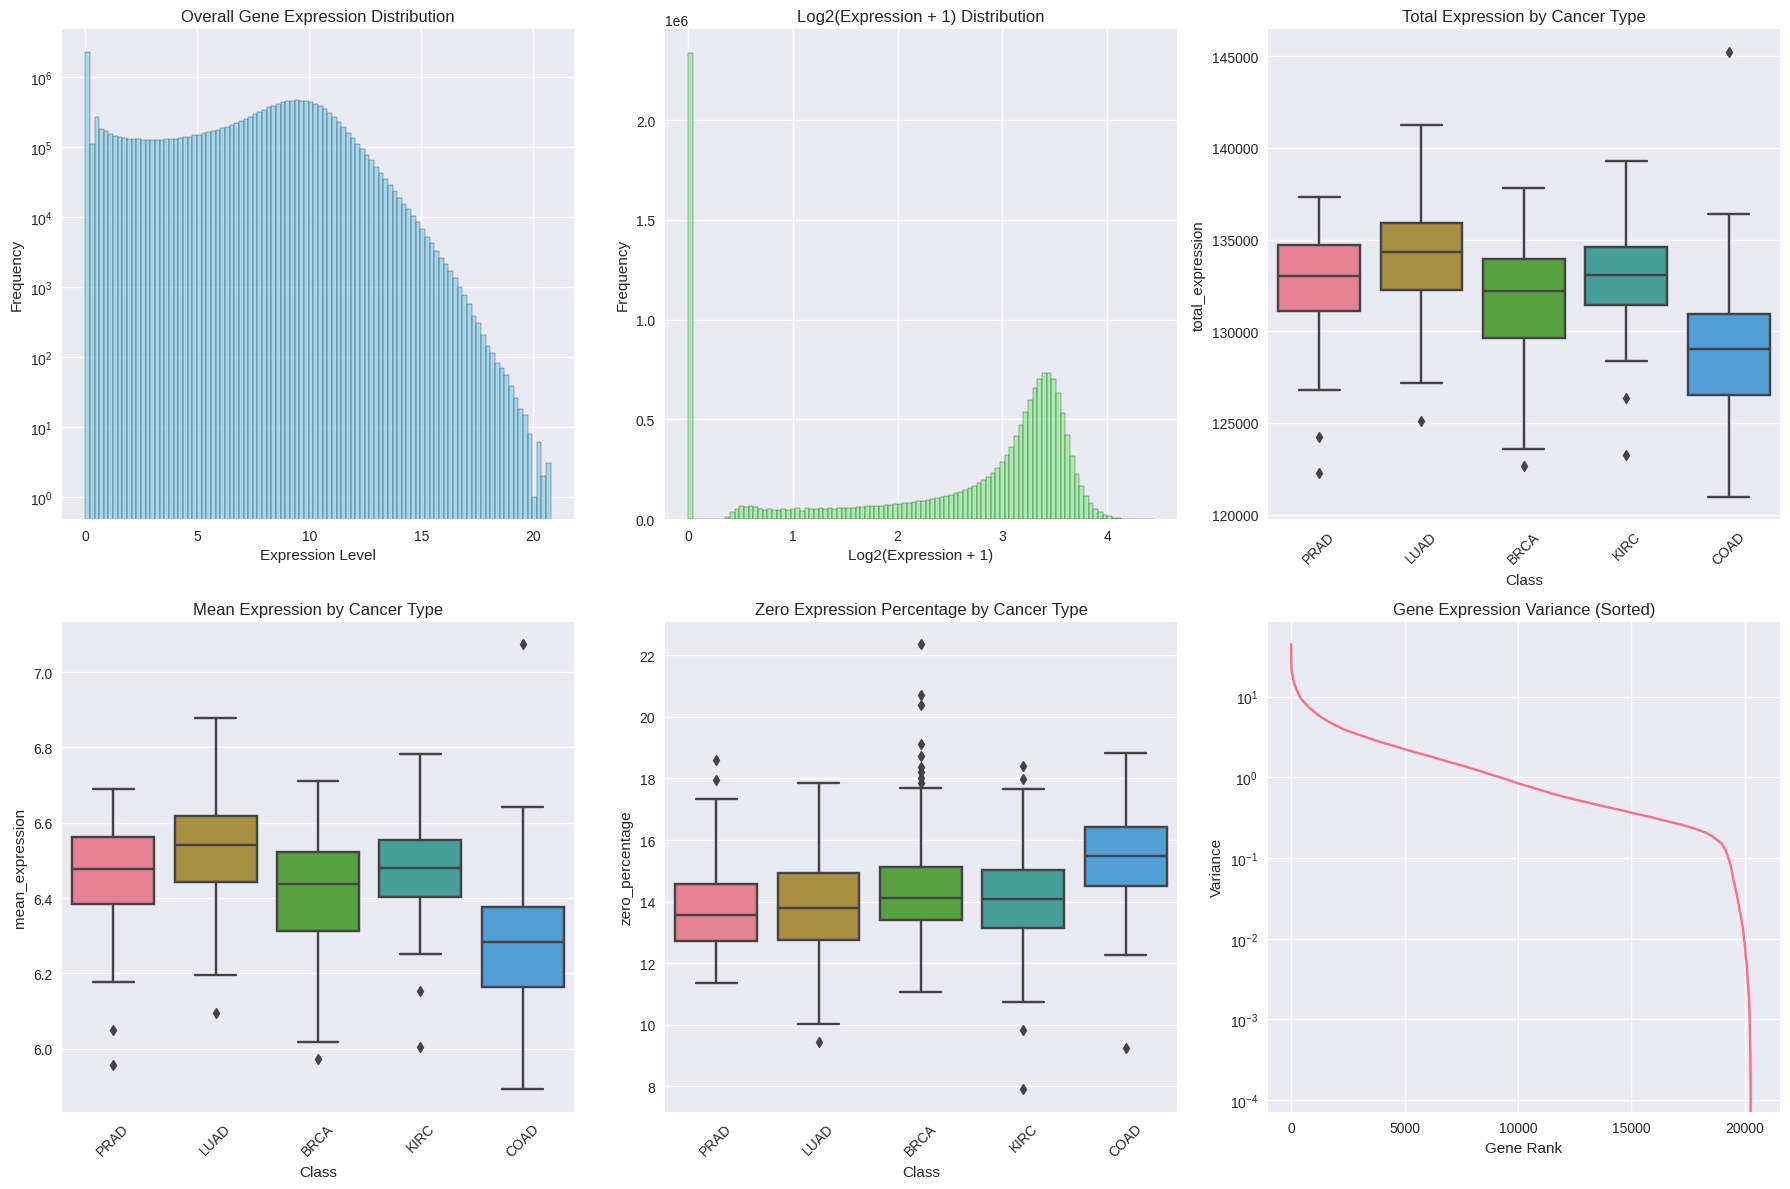

=== TOP 10 MOST VARIABLE GENES ===
gene_9176     44.763849
gene_9175     36.361940
gene_15898    34.503915
gene_15301    33.458776
gene_15589    31.325845
gene_3540     30.587696
gene_19661    30.080478
gene_3541     28.721689
gene_11250    26.515887
gene_15897    26.019446
dtype: float64


In [7]:
# Analyze expression distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Overall expression distribution
axes[0, 0].hist(data.values.flatten(), bins=100, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Overall Gene Expression Distribution')
axes[0, 0].set_xlabel('Expression Level')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# Log-transformed distribution (adding small constant to handle zeros)
log_data = np.log2(data + 1)
axes[0, 1].hist(log_data.values.flatten(), bins=100, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Log2(Expression + 1) Distribution')
axes[0, 1].set_xlabel('Log2(Expression + 1)')
axes[0, 1].set_ylabel('Frequency')

# Sample total expression by cancer type
merged_data = sample_stats.merge(labels, left_index=True, right_index=True)
sns.boxplot(data=merged_data, x='Class', y='total_expression', ax=axes[0, 2])
axes[0, 2].set_title('Total Expression by Cancer Type')
axes[0, 2].tick_params(axis='x', rotation=45)

# Mean expression by cancer type
sns.boxplot(data=merged_data, x='Class', y='mean_expression', ax=axes[1, 0])
axes[1, 0].set_title('Mean Expression by Cancer Type')
axes[1, 0].tick_params(axis='x', rotation=45)

# Zero percentage by cancer type
sns.boxplot(data=merged_data, x='Class', y='zero_percentage', ax=axes[1, 1])
axes[1, 1].set_title('Zero Expression Percentage by Cancer Type')
axes[1, 1].tick_params(axis='x', rotation=45)

# Expression variance across genes
gene_variance = data.var(axis=0).sort_values(ascending=False)
axes[1, 2].plot(range(len(gene_variance)), gene_variance.values)
axes[1, 2].set_title('Gene Expression Variance (Sorted)')
axes[1, 2].set_xlabel('Gene Rank')
axes[1, 2].set_ylabel('Variance')
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

# Print high variance genes
print(f"=== TOP 10 MOST VARIABLE GENES ===")
print(gene_variance.head(10))

## Cell 6: Quality Control and Outlier Detection


=== QUALITY CONTROL ANALYSIS ===
Outlier samples detected: 7
Outlier samples:
            total_expression  zero_percentage
sample_2       122275.042327        17.232478
sample_190     141222.453479         9.434514
sample_308     120970.343074        18.834933
sample_396     123265.494077        18.391700
sample_633     122623.160452        19.122303
sample_663     123575.249699        18.196873
sample_798     145246.945578         9.229945


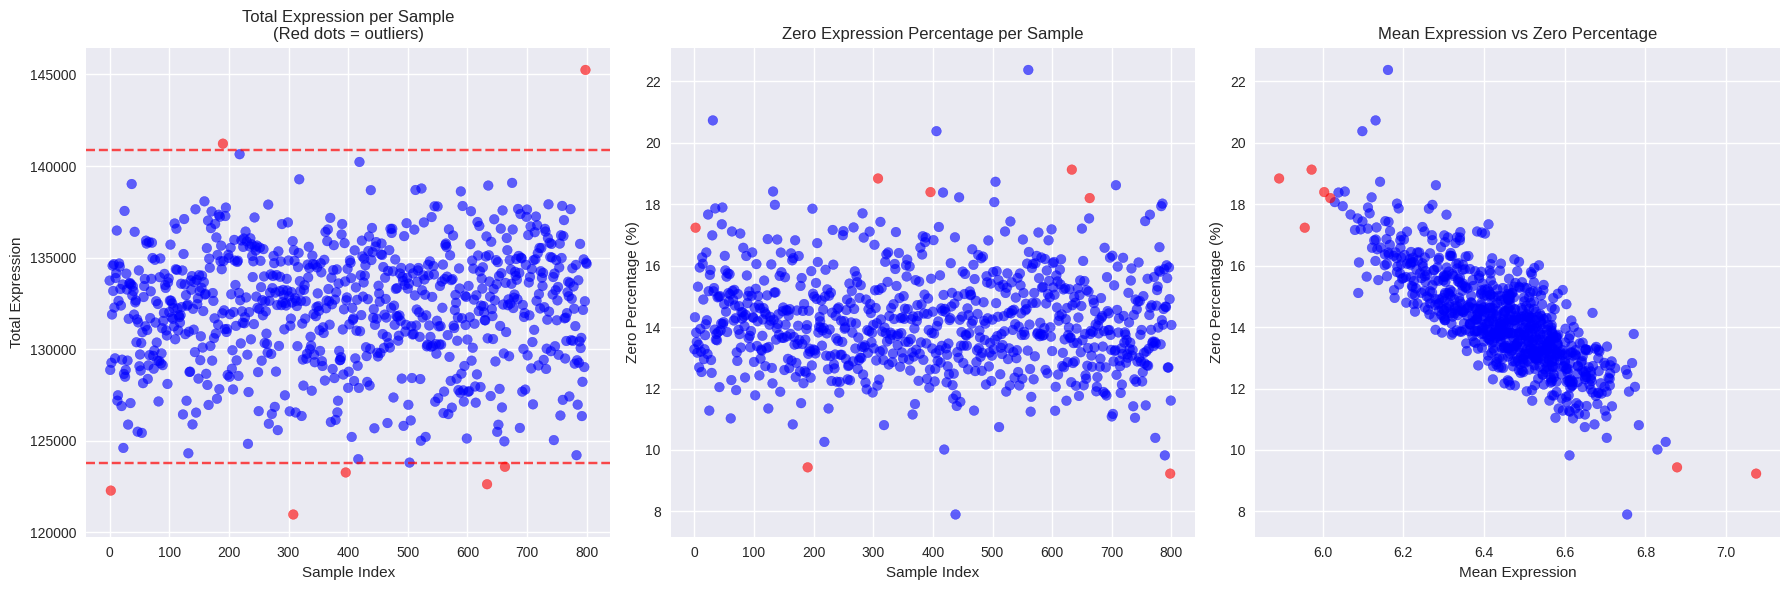


=== SAMPLE CORRELATION ANALYSIS ===
Mean inter-sample correlation: 0.8948
Samples with low correlation (< 0.8710): 40


In [8]:
# Quality control analysis
print("=== QUALITY CONTROL ANALYSIS ===")

# Detect outlier samples based on total expression
Q1 = sample_stats['total_expression'].quantile(0.25)
Q3 = sample_stats['total_expression'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_samples = sample_stats[
    (sample_stats['total_expression'] < lower_bound) | 
    (sample_stats['total_expression'] > upper_bound)
]

print(f"Outlier samples detected: {len(outlier_samples)}")
if len(outlier_samples) > 0:
    print("Outlier samples:")
    print(outlier_samples[['total_expression', 'zero_percentage']])

# Visualize potential outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total expression outliers
merged_data['outlier'] = merged_data.index.isin(outlier_samples.index)
colors = ['red' if x else 'blue' for x in merged_data['outlier']]

axes[0].scatter(range(len(merged_data)), merged_data['total_expression'], 
                c=colors, alpha=0.6)
axes[0].axhline(y=lower_bound, color='red', linestyle='--', alpha=0.7)
axes[0].axhline(y=upper_bound, color='red', linestyle='--', alpha=0.7)
axes[0].set_title('Total Expression per Sample\n(Red dots = outliers)')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Total Expression')

# Zero percentage distribution
axes[1].scatter(range(len(merged_data)), merged_data['zero_percentage'], 
                c=colors, alpha=0.6)
axes[1].set_title('Zero Expression Percentage per Sample')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Zero Percentage (%)')

# Mean vs zero percentage
axes[2].scatter(merged_data['mean_expression'], merged_data['zero_percentage'], 
                c=colors, alpha=0.6)
axes[2].set_title('Mean Expression vs Zero Percentage')
axes[2].set_xlabel('Mean Expression')
axes[2].set_ylabel('Zero Percentage (%)')

plt.tight_layout()
plt.show()

# Check correlation between samples (sample QC)
print(f"\n=== SAMPLE CORRELATION ANALYSIS ===")
sample_corr = data.T.corr()
mean_correlation = sample_corr.mean().mean()
print(f"Mean inter-sample correlation: {mean_correlation:.4f}")

# Find samples with low correlation to others
low_corr_threshold = sample_corr.mean().quantile(0.05)  # Bottom 5%
low_corr_samples = sample_corr.mean()[sample_corr.mean() < low_corr_threshold]
print(f"Samples with low correlation (< {low_corr_threshold:.4f}): {len(low_corr_samples)}")

## Cell 7: Gene Filtering and Selection



=== GENE FILTERING ===
Genes before filtering: 20531
Genes expressed in ≥80 samples: 18532
Genes with variance > 0.1929: 18477
Final filtered genes: 17987
Reduction: 12.4%


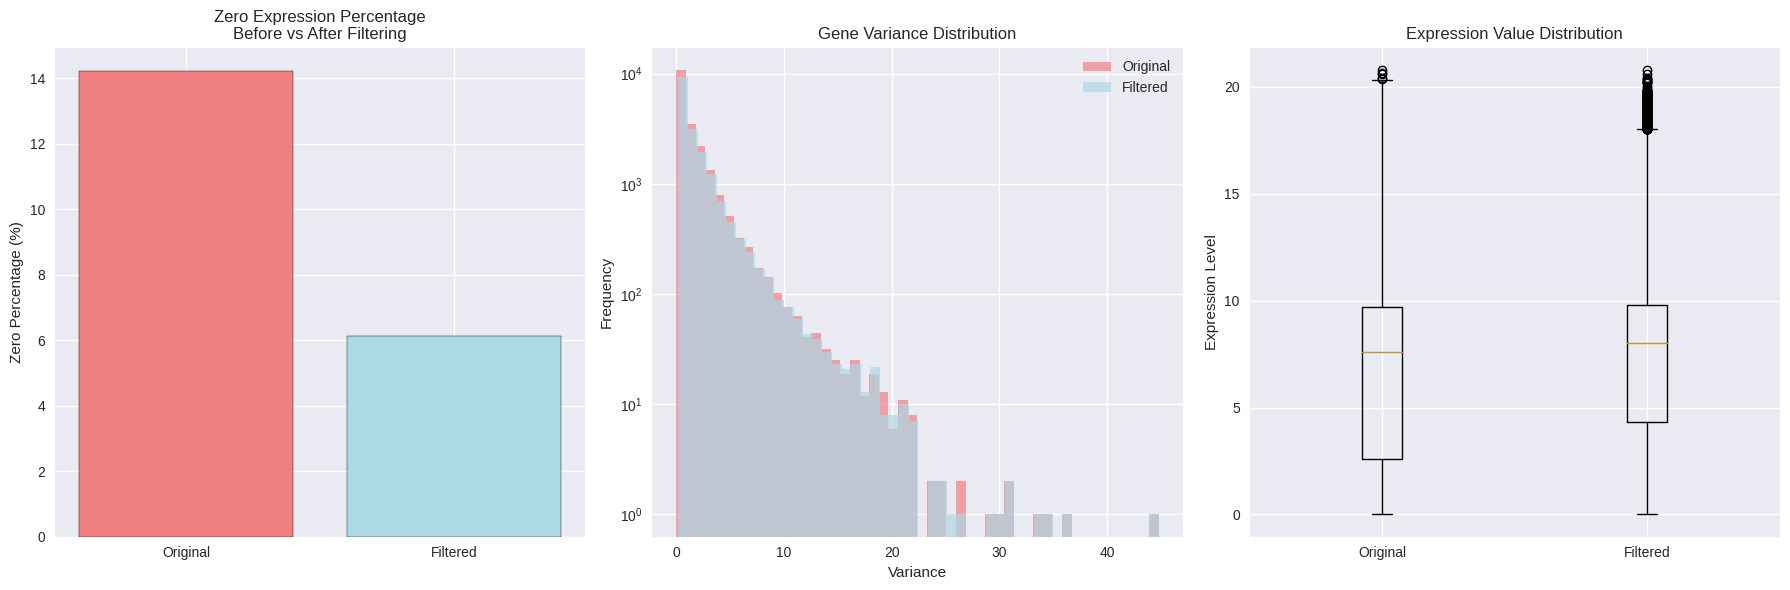


=== FILTERED DATA SUMMARY ===
Shape: (801, 17987)
Expression range: [0.000, 20.779]
Mean expression: 7.035


In [9]:
# Gene filtering based on expression characteristics
print("=== GENE FILTERING ===")

# Filter genes with low expression and high zero counts
min_samples_expressed = int(0.1 * len(data))  # At least 10% of samples
min_expression_level = 1.0  # Minimum expression threshold

# Genes expressed in sufficient samples
expressed_mask = (data > min_expression_level).sum(axis=0) >= min_samples_expressed
expressed_genes = data.columns[expressed_mask]

print(f"Genes before filtering: {data.shape[1]}")
print(f"Genes expressed in ≥{min_samples_expressed} samples: {len(expressed_genes)}")

# Filter low variance genes (bottom 10%)
variance_threshold = gene_variance.quantile(0.1)
high_var_genes = gene_variance[gene_variance > variance_threshold].index

print(f"Genes with variance > {variance_threshold:.4f}: {len(high_var_genes)}")

# Combine filters
filtered_genes = list(set(expressed_genes) & set(high_var_genes))
filtered_data = data[filtered_genes]

print(f"Final filtered genes: {len(filtered_genes)}")
print(f"Reduction: {((data.shape[1] - len(filtered_genes)) / data.shape[1] * 100):.1f}%")

# Visualize filtering effects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Before and after zero counts
before_zeros = (data == 0).sum().sum()
after_zeros = (filtered_data == 0).sum().sum()

zero_comparison = pd.DataFrame({
    'Dataset': ['Original', 'Filtered'],
    'Zero_Count': [before_zeros, after_zeros],
    'Total_Values': [data.size, filtered_data.size]
})
zero_comparison['Zero_Percentage'] = zero_comparison['Zero_Count'] / zero_comparison['Total_Values'] * 100

axes[0].bar(zero_comparison['Dataset'], zero_comparison['Zero_Percentage'], 
            color=['lightcoral', 'lightblue'], edgecolor='black')
axes[0].set_title('Zero Expression Percentage\nBefore vs After Filtering')
axes[0].set_ylabel('Zero Percentage (%)')

# Variance distribution comparison
axes[1].hist(gene_variance.values, bins=50, alpha=0.7, label='Original', color='lightcoral')
axes[1].hist(filtered_data.var(axis=0).values, bins=50, alpha=0.7, label='Filtered', color='lightblue')
axes[1].set_title('Gene Variance Distribution')
axes[1].set_xlabel('Variance')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].set_yscale('log')

# Expression range comparison
axes[2].boxplot([data.values.flatten(), filtered_data.values.flatten()], 
                labels=['Original', 'Filtered'])
axes[2].set_title('Expression Value Distribution')
axes[2].set_ylabel('Expression Level')

plt.tight_layout()
plt.show()

print(f"\n=== FILTERED DATA SUMMARY ===")
print(f"Shape: {filtered_data.shape}")
print(f"Expression range: [{filtered_data.values.min():.3f}, {filtered_data.values.max():.3f}]")
print(f"Mean expression: {filtered_data.values.mean():.3f}")

## Cell 8: Data Normalization and Transformation


=== DATA NORMALIZATION ===


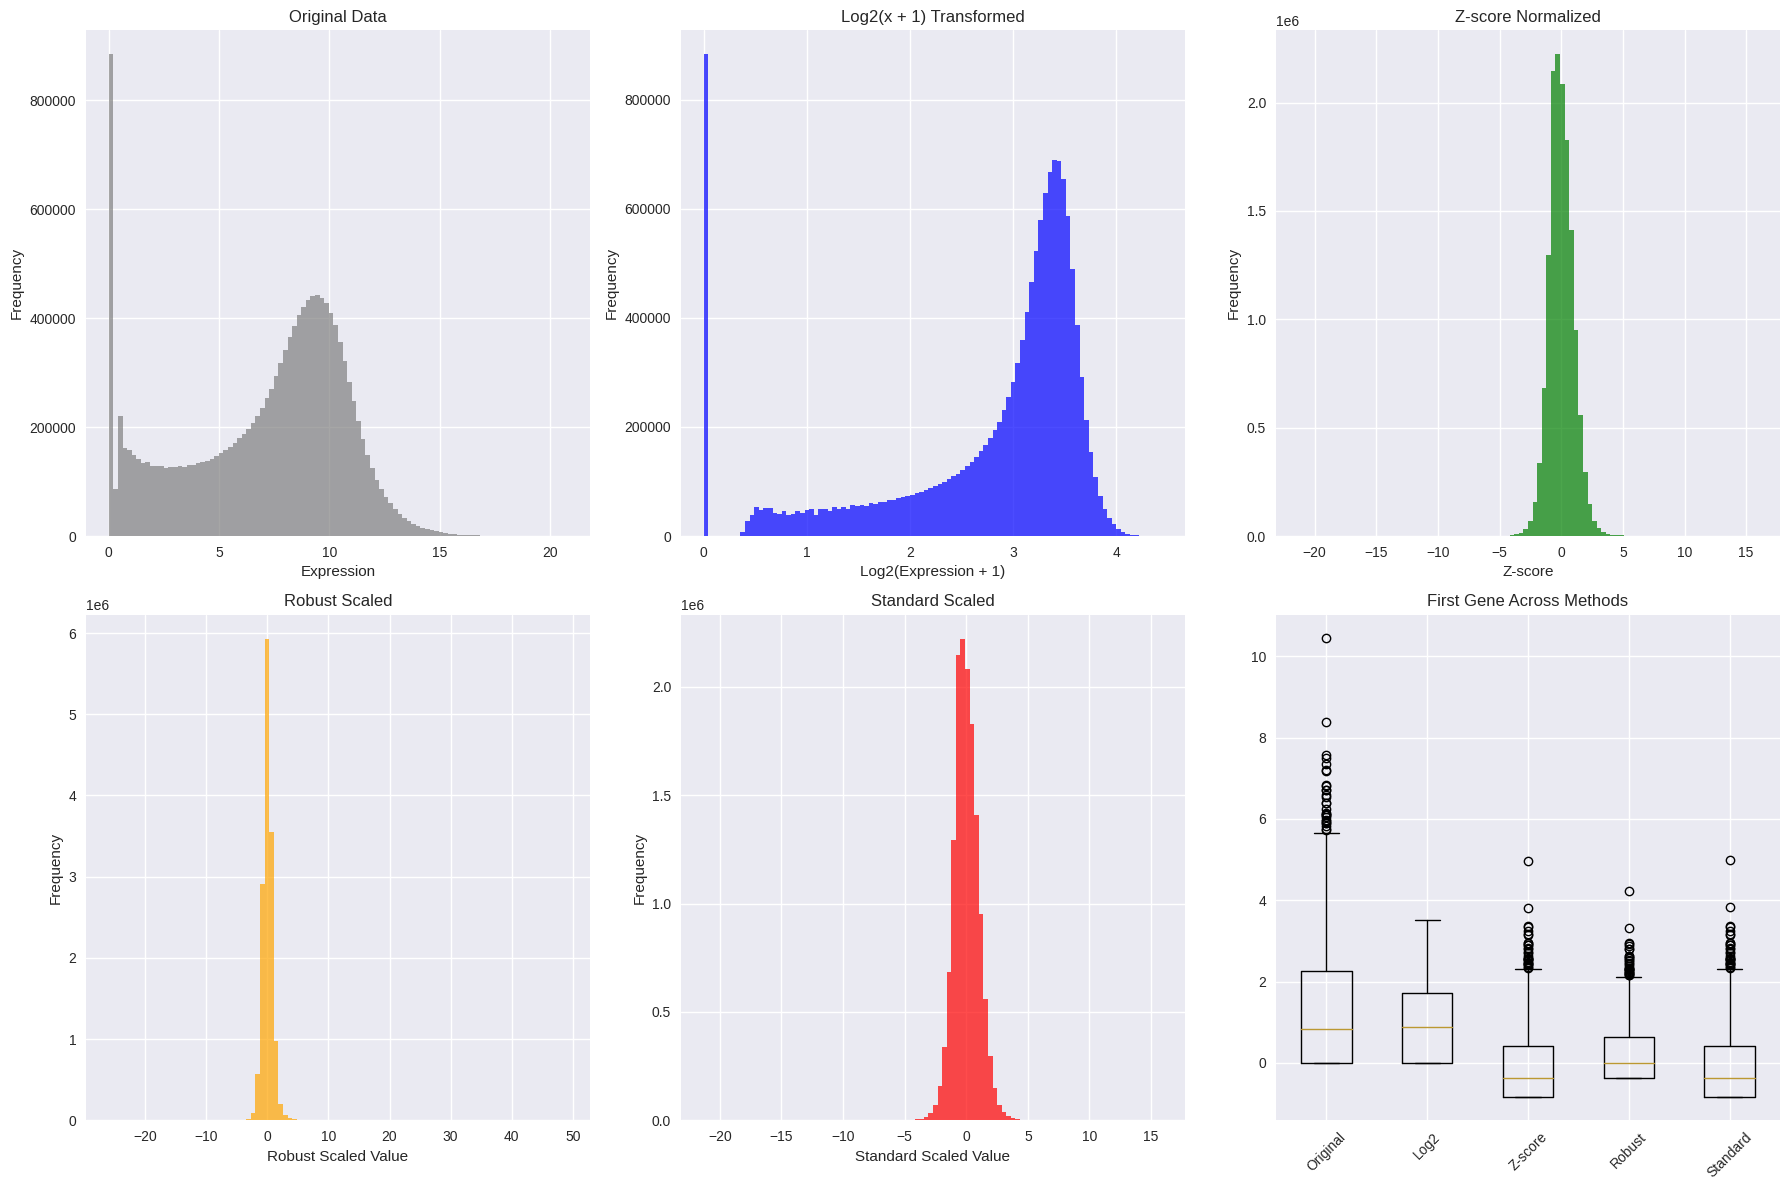


=== FINAL PROCESSED DATA ===
Selected normalization: Log2(x + 1) transformation
Final data shape: (801, 17987)
Value range: [0.000, 4.445]
Mean: 2.741, Std: 1.034


In [10]:
# Data normalization and transformation
print("=== DATA NORMALIZATION ===")

# 1. Log2 transformation (common for RNA-seq data)
log_transformed_data = np.log2(filtered_data + 1)

# 2. Z-score normalization (per gene)
zscore_data = filtered_data.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# 3. Robust scaling (less sensitive to outliers)
robust_scaler = RobustScaler()
robust_scaled_data = pd.DataFrame(
    robust_scaler.fit_transform(filtered_data),
    index=filtered_data.index,
    columns=filtered_data.columns
)

# 4. Standard scaling
standard_scaler = StandardScaler()
standard_scaled_data = pd.DataFrame(
    standard_scaler.fit_transform(filtered_data),
    index=filtered_data.index,
    columns=filtered_data.columns
)

# Compare normalization methods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original data
axes[0, 0].hist(filtered_data.values.flatten(), bins=100, alpha=0.7, color='gray')
axes[0, 0].set_title('Original Data')
axes[0, 0].set_xlabel('Expression')
axes[0, 0].set_ylabel('Frequency')

# Log-transformed
axes[0, 1].hist(log_transformed_data.values.flatten(), bins=100, alpha=0.7, color='blue')
axes[0, 1].set_title('Log2(x + 1) Transformed')
axes[0, 1].set_xlabel('Log2(Expression + 1)')
axes[0, 1].set_ylabel('Frequency')

# Z-score normalized
axes[0, 2].hist(zscore_data.values.flatten(), bins=100, alpha=0.7, color='green')
axes[0, 2].set_title('Z-score Normalized')
axes[0, 2].set_xlabel('Z-score')
axes[0, 2].set_ylabel('Frequency')

# Robust scaled
axes[1, 0].hist(robust_scaled_data.values.flatten(), bins=100, alpha=0.7, color='orange')
axes[1, 0].set_title('Robust Scaled')
axes[1, 0].set_xlabel('Robust Scaled Value')
axes[1, 0].set_ylabel('Frequency')

# Standard scaled
axes[1, 1].hist(standard_scaled_data.values.flatten(), bins=100, alpha=0.7, color='red')
axes[1, 1].set_title('Standard Scaled')
axes[1, 1].set_xlabel('Standard Scaled Value')
axes[1, 1].set_ylabel('Frequency')

# Comparison of first gene across methods
gene_idx = 0
methods_data = [
    filtered_data.iloc[:, gene_idx],
    log_transformed_data.iloc[:, gene_idx],
    zscore_data.iloc[:, gene_idx],
    robust_scaled_data.iloc[:, gene_idx],
    standard_scaled_data.iloc[:, gene_idx]
]
axes[1, 2].boxplot(methods_data, labels=['Original', 'Log2', 'Z-score', 'Robust', 'Standard'])
axes[1, 2].set_title(f'First Gene Across Methods')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Choose the best normalization method (log2 transformation is common for RNA-seq)
final_data = log_transformed_data.copy()
print(f"\n=== FINAL PROCESSED DATA ===")
print(f"Selected normalization: Log2(x + 1) transformation")
print(f"Final data shape: {final_data.shape}")
print(f"Value range: [{final_data.values.min():.3f}, {final_data.values.max():.3f}]")
print(f"Mean: {final_data.values.mean():.3f}, Std: {final_data.values.std():.3f}")

## Cell 9: Dimensionality Reduction and Visualization



=== DIMENSIONALITY REDUCTION ===
Components for 90% variance: 407
Components for 95% variance: 554
Computing t-SNE...


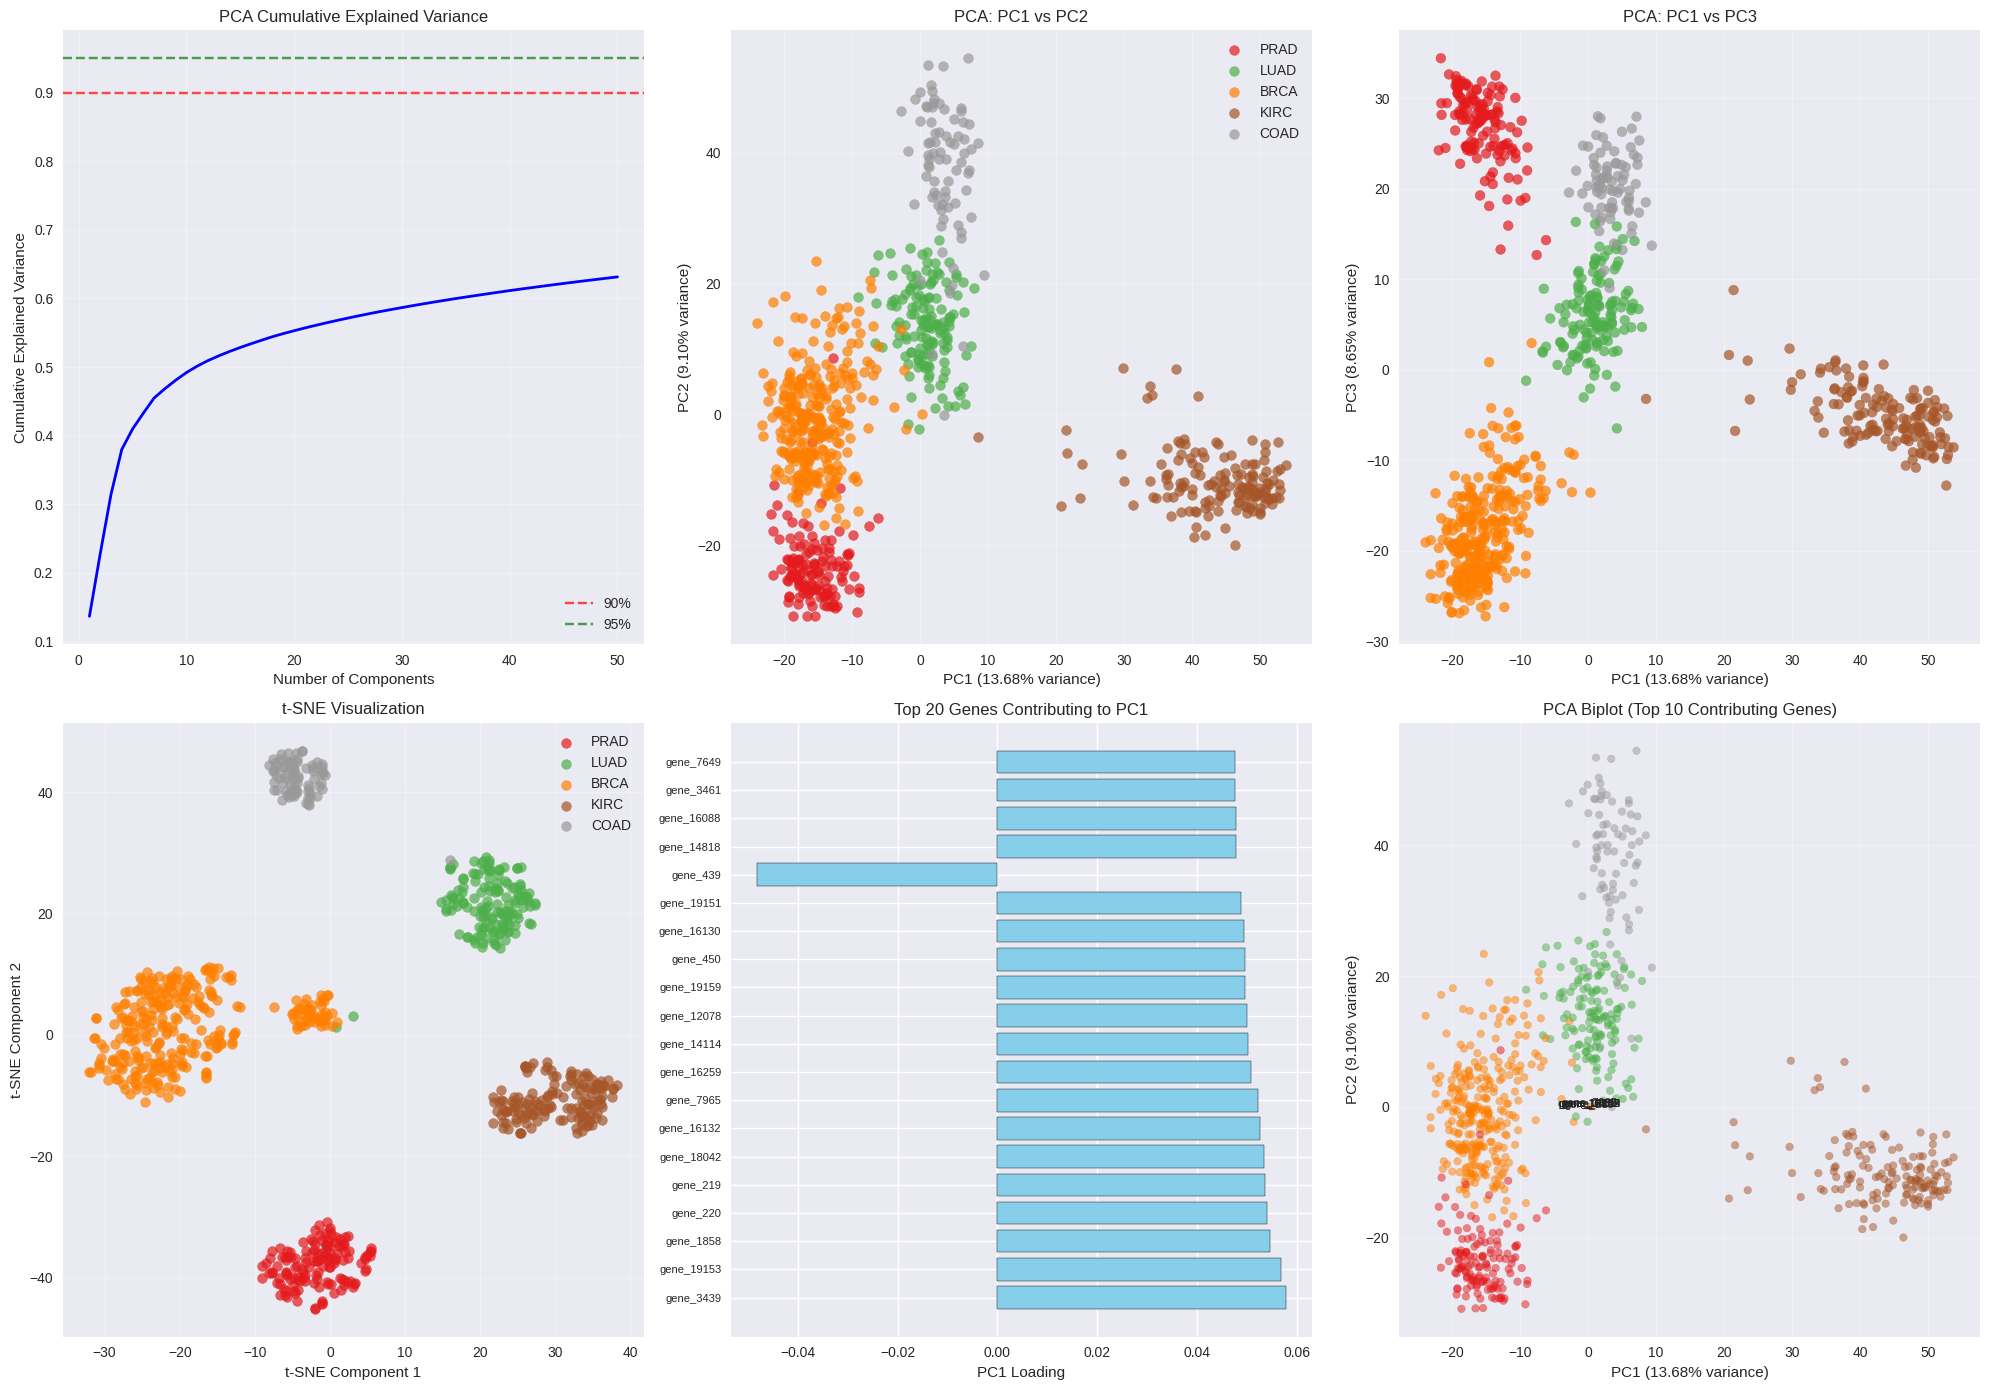

In [11]:
# Dimensionality reduction for visualization
print("=== DIMENSIONALITY REDUCTION ===")

# PCA Analysis
pca = PCA()
pca_result = pca.fit_transform(final_data)

# Explained variance
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1

print(f"Components for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")

# Create PCA dataframe
pca_df = pd.DataFrame(
    pca_result[:, :3],  # First 3 components
    columns=['PC1', 'PC2', 'PC3'],
    index=final_data.index
)
pca_df = pca_df.merge(labels, left_index=True, right_index=True)

# t-SNE (on first 50 PCA components for efficiency)
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(pca_result[:, :50])

tsne_df = pd.DataFrame(
    tsne_result,
    columns=['TSNE1', 'TSNE2'],
    index=final_data.index
)
tsne_df = tsne_df.merge(labels, left_index=True, right_index=True)

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 14))

# PCA variance explained
axes[0, 0].plot(range(1, min(51, len(cumsum_var) + 1)), cumsum_var[:50], 'b-', linewidth=2)
axes[0, 0].axhline(y=0.90, color='r', linestyle='--', alpha=0.7, label='90%')
axes[0, 0].axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95%')
axes[0, 0].set_title('PCA Cumulative Explained Variance')
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Cumulative Explained Variance')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# PCA 2D plot
colors = plt.cm.Set1(np.linspace(0, 1, len(pca_df['Class'].unique())))
for i, cancer_type in enumerate(pca_df['Class'].unique()):
    mask = pca_df['Class'] == cancer_type
    axes[0, 1].scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], 
                      c=[colors[i]], label=cancer_type, alpha=0.7, s=50)
axes[0, 1].set_title('PCA: PC1 vs PC2')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# PCA 3D components
axes[0, 2].scatter(pca_df['PC1'], pca_df['PC3'], c=[colors[list(pca_df['Class'].unique()).index(x)] for x in pca_df['Class']], alpha=0.7, s=50)
axes[0, 2].set_title('PCA: PC1 vs PC3')
axes[0, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 2].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
axes[0, 2].grid(True, alpha=0.3)

# t-SNE plot
for i, cancer_type in enumerate(tsne_df['Class'].unique()):
    mask = tsne_df['Class'] == cancer_type
    axes[1, 0].scatter(tsne_df[mask]['TSNE1'], tsne_df[mask]['TSNE2'], 
                      c=[colors[i]], label=cancer_type, alpha=0.7, s=50)
axes[1, 0].set_title('t-SNE Visualization')
axes[1, 0].set_xlabel('t-SNE Component 1')
axes[1, 0].set_ylabel('t-SNE Component 2')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature importance (top loadings for PC1)
feature_importance = pd.DataFrame({
    'Gene': final_data.columns,
    'PC1_Loading': pca.components_[0],
    'PC2_Loading': pca.components_[1]
})
feature_importance['PC1_Abs'] = np.abs(feature_importance['PC1_Loading'])
top_features = feature_importance.nlargest(20, 'PC1_Abs')

axes[1, 1].barh(range(len(top_features)), top_features['PC1_Loading'], color='skyblue', edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Gene'], fontsize=8)
axes[1, 1].set_title('Top 20 Genes Contributing to PC1')
axes[1, 1].set_xlabel('PC1 Loading')

# Biplot-style visualization (PC1 vs PC2 with top features)
axes[1, 2].scatter(pca_df['PC1'], pca_df['PC2'], 
                  c=[colors[list(pca_df['Class'].unique()).index(x)] for x in pca_df['Class']], 
                  alpha=0.5, s=30)

# Add arrows for top contributing features
scale_factor = 3
top_10_features = feature_importance.nlargest(10, 'PC1_Abs')
for _, feature in top_10_features.iterrows():
    axes[1, 2].arrow(0, 0, 
                    feature['PC1_Loading'] * scale_factor, 
                    feature['PC2_Loading'] * scale_factor,
                    head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
    axes[1, 2].text(feature['PC1_Loading'] * scale_factor * 1.1, 
                   feature['PC2_Loading'] * scale_factor * 1.1,
                   feature['Gene'], fontsize=8, ha='center')

axes[1, 2].set_title('PCA Biplot (Top 10 Contributing Genes)')
axes[1, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cell 10: Final Data Summary and Export



In [12]:
# Final summary and data export
print("=== FINAL DATA PROCESSING SUMMARY ===")

# Create final processed datasets
processed_data = {
    'original_data': data,
    'filtered_data': filtered_data,
    'normalized_data': final_data,
    'labels': labels,
    'pca_components': pca_df,
    'tsne_components': tsne_df
}

# Summary statistics
summary_stats = pd.DataFrame({
    'Original': [data.shape[0], data.shape[1], (data == 0).sum().sum() / data.size * 100, 
                data.values.mean(), data.values.std()],
    'Filtered': [filtered_data.shape[0], filtered_data.shape[1], 
                (filtered_data == 0).sum().sum() / filtered_data.size * 100,
                filtered_data.values.mean(), filtered_data.values.std()],
    'Normalized': [final_data.shape[0], final_data.shape[1], 
                  (final_data == 0).sum().sum() / final_data.size * 100,
                  final_data.values.mean(), final_data.values.std()]
}, index=['Samples', 'Genes', 'Zero_Percentage', 'Mean_Expression', 'Std_Expression'])

print(summary_stats.round(3))

# Quality metrics
print(f"\n=== QUALITY METRICS ===")
print(f"Genes removed by filtering: {data.shape[1] - filtered_data.shape[1]} ({((data.shape[1] - filtered_data.shape[1]) / data.shape[1] * 100):.1f}%)")
print(f"Samples retained: {final_data.shape[0]}")
print(f"Final feature space: {final_data.shape[1]} genes")
print(f"Class distribution maintained: {labels['Class'].value_counts().to_dict()}")

# Save processed data
print(f"\n=== SAVING PROCESSED DATA ===")
final_data.to_csv('processed_gene_expression_data.csv')
labels.to_csv('processed_labels.csv')
pca_df.to_csv('pca_components.csv')
tsne_df.to_csv('tsne_components.csv')

# Save feature importance
feature_importance.to_csv('feature_importance_pca.csv', index=False)

print("Processed data saved successfully!")
print("\nFiles created:")
print("- processed_gene_expression_data.csv: Log2-normalized gene expression data")
print("- processed_labels.csv: Sample labels")
print("- pca_components.csv: PCA components with labels")
print("- tsne_components.csv: t-SNE components with labels")
print("- feature_importance_pca.csv: Gene importance based on PCA loadings")

# Data readiness for machine learning
print(f"\n=== MACHINE LEARNING READINESS ===")
print("✓ Data is normalized (log2 transformation)")
print("✓ Low-quality genes removed")
print("✓ No missing values")
print("✓ Balanced class representation maintained")
print("✓ Dimensionality reduction components available")
print("✓ Feature importance identified")
print("\nData is ready for machine learning tasks!")

=== FINAL DATA PROCESSING SUMMARY ===
                  Original   Filtered  Normalized
Samples            801.000    801.000     801.000
Genes            20531.000  17987.000   17987.000
Zero_Percentage     14.218      6.128       6.128
Mean_Expression      6.443      7.035       2.741
Std_Expression       4.058      3.668       1.034

=== QUALITY METRICS ===
Genes removed by filtering: 2544 (12.4%)
Samples retained: 801
Final feature space: 17987 genes
Class distribution maintained: {'BRCA': 300, 'KIRC': 146, 'LUAD': 141, 'PRAD': 136, 'COAD': 78}

=== SAVING PROCESSED DATA ===
Processed data saved successfully!

Files created:
- processed_gene_expression_data.csv: Log2-normalized gene expression data
- processed_labels.csv: Sample labels
- pca_components.csv: PCA components with labels
- tsne_components.csv: t-SNE components with labels
- feature_importance_pca.csv: Gene importance based on PCA loadings

=== MACHINE LEARNING READINESS ===
✓ Data is normalized (log2 transformation)
✓ 

____________

# Applying ML Algorithms

## Cell 1: Import ML Libraries and Load Preprocessed Data



In [28]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
X = pd.read_csv('processed_gene_expression_data.csv', index_col=0)
y = pd.read_csv('processed_labels.csv', index_col=0)['Class']

print(f"Data shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Classes: {y.unique()}")

Data shape: (801, 17987)
Target shape: (801,)
Classes: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


In [25]:
# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution in train: {np.bincount(y_train)}")
print(f"Class distribution in test: {np.bincount(y_test)}")

Training set: (640, 17987)
Test set: (161, 17987)
Class distribution in train: [240  62 116 113 109]
Class distribution in test: [60 16 30 28 27]


In [30]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
}

print(f"Initialized {len(models)} models")

Initialized 6 models


In [31]:
# Cross-validation evaluation
cv_results = {}
cv_scores = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Cross-validation scores
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    cv_scores[name] = scores
    cv_results[name] = {
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std(),
        'scores': scores
    }

# Display results
cv_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean_Accuracy': [cv_results[k]['mean_accuracy'] for k in cv_results.keys()],
    'Std_Accuracy': [cv_results[k]['std_accuracy'] for k in cv_results.keys()]
}).sort_values('Mean_Accuracy', ascending=False)

print("\nCross-Validation Results:")
print(cv_df)

Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating SVM...
Evaluating K-Nearest Neighbors...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Evaluating Naive Bayes...
Evaluating Decision Tree...

Cross-Validation Results:
                 Model  Mean_Accuracy  Std_Accuracy
0  Logistic Regression       0.998437      0.003125
3  K-Nearest Neighbors       0.998437      0.003125
1        Random Forest       0.996875      0.003827
2                  SVM       0.996875      0.003827
5        Decision Tree       0.971875      0.016829
4          Naive Bayes       0.929688      0.009882


In [32]:
# Train and evaluate all models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Results summary
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[k]['accuracy'] for k in results.keys()],
    'F1_Score': [results[k]['f1_score'] for k in results.keys()],
    'Precision': [results[k]['precision'] for k in results.keys()],
    'Recall': [results[k]['recall'] for k in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("\nTest Set Results:")
print(results_df)

Training Logistic Regression...
Training Random Forest...
Training SVM...
Training K-Nearest Neighbors...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Training Naive Bayes...
Training Decision Tree...

Test Set Results:
                 Model  Accuracy  F1_Score  Precision    Recall
0  Logistic Regression  0.993789  0.993758   0.993891  0.993789
1        Random Forest  0.993789  0.993758   0.993891  0.993789
3  K-Nearest Neighbors  0.993789  0.993758   0.993891  0.993789
2                  SVM  0.987578  0.987503   0.987679  0.987578
5        Decision Tree  0.987578  0.987539   0.987880  0.987578
4          Naive Bayes  0.925466  0.925702   0.937247  0.925466


In [33]:
# Hyperparameter tuning for top 3 models
top_models = results_df.head(3)['Model'].tolist()

param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
}

tuned_models = {}

for model_name in top_models:
    if model_name in param_grids:
        print(f"Tuning {model_name}...")
        
        grid_search = GridSearchCV(
            models[model_name], 
            param_grids[model_name],
            cv=3, 
            scoring='accuracy',
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        tuned_models[model_name] = grid_search.best_estimator_
        
        print(f"Best params for {model_name}: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")

Tuning Logistic Regression...
Best params for Logistic Regression: {'C': 0.01, 'solver': 'lbfgs'}
Best CV score: 0.9984
Tuning Random Forest...
Best params for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 0.9969


In [34]:
# Evaluate tuned models
tuned_results = {}

for name, model in tuned_models.items():
    print(f"Evaluating tuned {name}...")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    tuned_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Compare original vs tuned
comparison_df = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'Original_Accuracy': [results[k]['accuracy'] for k in tuned_results.keys()],
    'Tuned_Accuracy': [tuned_results[k]['accuracy'] for k in tuned_results.keys()],
    'Improvement': [tuned_results[k]['accuracy'] - results[k]['accuracy'] for k in tuned_results.keys()]
})

print("Original vs Tuned Model Comparison:")
print(comparison_df)

Evaluating tuned Logistic Regression...
Evaluating tuned Random Forest...
Original vs Tuned Model Comparison:
                 Model  Original_Accuracy  Tuned_Accuracy  Improvement
0  Logistic Regression           0.993789        0.993789     0.000000
1        Random Forest           0.993789        0.987578    -0.006211


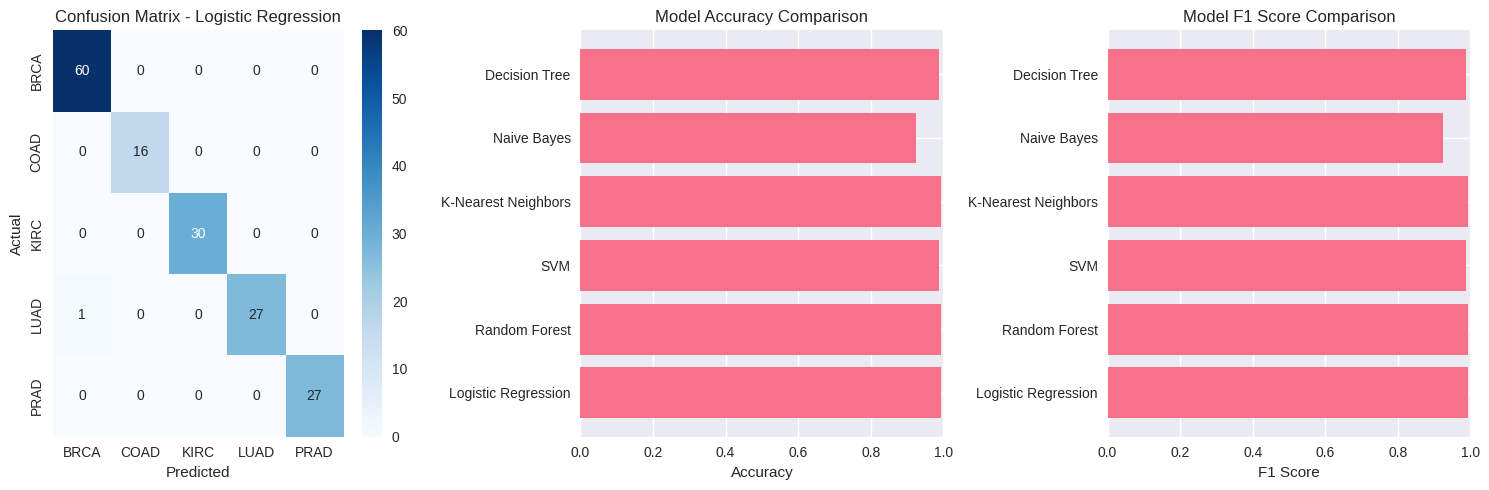


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      0.96      0.98        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



In [35]:
# Generate confusion matrices and classification reports
best_model_name = max(tuned_results.keys(), key=lambda k: tuned_results[k]['accuracy'])
best_model = tuned_results[best_model_name]

# Confusion matrix for best model
cm = confusion_matrix(y_test, best_model['y_pred'])

plt.figure(figsize=(15, 5))

# Confusion matrix heatmap
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Accuracy comparison
plt.subplot(1, 3, 2)
model_names = list(results.keys())
accuracies = [results[k]['accuracy'] for k in model_names]
plt.barh(model_names, accuracies)
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)

# F1 score comparison
plt.subplot(1, 3, 3)
f1_scores = [results[k]['f1_score'] for k in model_names]
plt.barh(model_names, f1_scores)
plt.xlabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

# Classification report
print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, best_model['y_pred'], target_names=le.classes_))

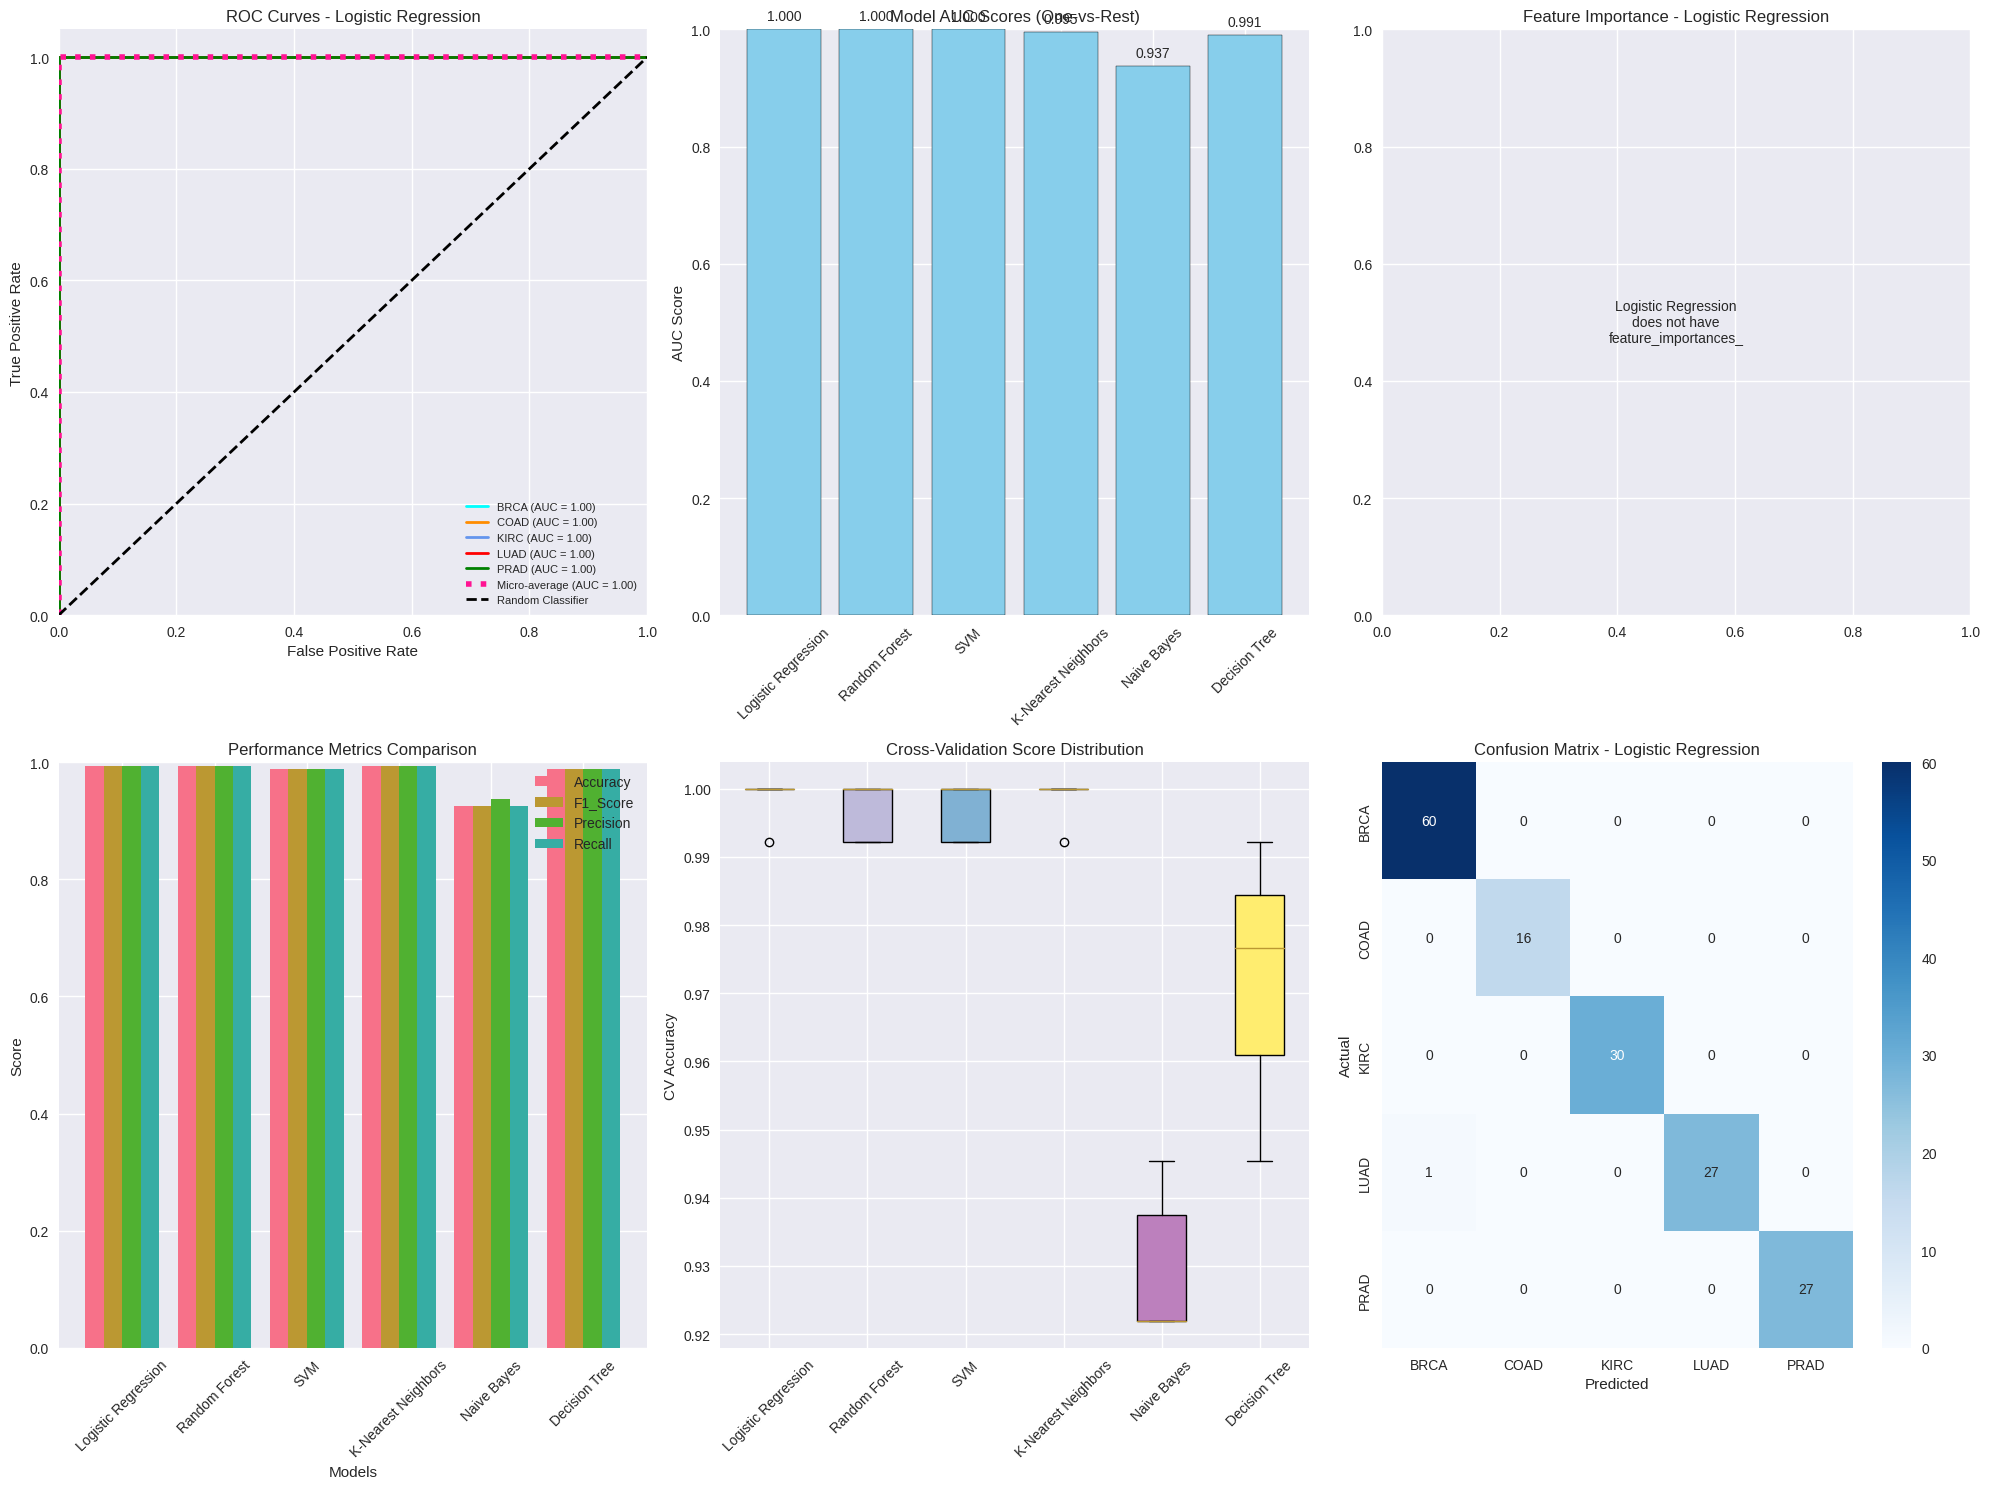


Detailed AUC Scores:
Logistic Regression: 1.0000
Random Forest: 1.0000
SVM: 0.9999
K-Nearest Neighbors: 0.9954
Decision Tree: 0.9910
Naive Bayes: 0.9369


In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# ROC curves and feature importance
plt.figure(figsize=(20, 15))

# ROC curves - Fixed for multiclass
plt.subplot(2, 3, 1)

# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
n_classes = len(le.classes_)

# Get the best model's probabilities
best_model_proba = None
best_model_name_for_roc = None

for name, result in results.items():
    if result['y_pred_proba'] is not None:
        best_model_proba = result['y_pred_proba']
        best_model_name_for_roc = name
        break

if best_model_proba is not None:
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], best_model_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), best_model_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {best_model_name_for_roc}')
plt.legend(loc="lower right", fontsize=8)

# Alternative: ROC AUC scores for all models
plt.subplot(2, 3, 2)
model_auc_scores = {}

for name, result in results.items():
    if result['y_pred_proba'] is not None:
        try:
            # Compute multiclass AUC using one-vs-rest
            auc_score = roc_auc_score(y_test, result['y_pred_proba'], multi_class='ovr')
            model_auc_scores[name] = auc_score
        except:
            model_auc_scores[name] = 0

if model_auc_scores:
    models_list = list(model_auc_scores.keys())
    auc_values = list(model_auc_scores.values())
    
    bars = plt.bar(models_list, auc_values, color='skyblue', edgecolor='black')
    plt.ylabel('AUC Score')
    plt.title('Model AUC Scores (One-vs-Rest)')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, auc_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom')

# Feature importance for tree-based models
plt.subplot(2, 3, 3)
# Check if we have tuned models, otherwise use original results
if 'tuned_results' in locals() and tuned_results:
    best_result = max(tuned_results.items(), key=lambda x: x[1]['accuracy'])
    best_model_name = best_result[0]
    best_model_obj = best_result[1]['model']
else:
    best_result = max(results.items(), key=lambda x: x[1]['accuracy'])
    best_model_name = best_result[0]
    best_model_obj = best_result[1]['model']

if hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
    top_features_idx = np.argsort(importances)[-20:]
    top_importances = importances[top_features_idx]
    
    plt.barh(range(20), top_importances, color='lightgreen', edgecolor='black')
    plt.yticks(range(20), [X.columns[i] for i in top_features_idx], fontsize=8)
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Features - {best_model_name}')
else:
    plt.text(0.5, 0.5, f'{best_model_name}\ndoes not have\nfeature_importances_', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title(f'Feature Importance - {best_model_name}')

# Model performance metrics comparison
plt.subplot(2, 3, 4)
metrics = ['Accuracy', 'F1_Score', 'Precision', 'Recall']
model_names = list(results.keys())
metric_data = {metric: [results[name][metric.lower()] for name in model_names] for metric in metrics}

x = np.arange(len(model_names))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_data[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x + width*1.5, model_names, rotation=45)
plt.legend()
plt.ylim(0, 1)

# Cross-validation scores distribution
plt.subplot(2, 3, 5)
cv_data = [cv_scores[name] for name in cv_scores.keys()]
box_plot = plt.boxplot(cv_data, labels=list(cv_scores.keys()), patch_artist=True)

# Color the boxes
colors = plt.cm.Set3(np.linspace(0, 1, len(box_plot['boxes'])))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('CV Accuracy')
plt.title('Cross-Validation Score Distribution')
plt.xticks(rotation=45)

# Confusion matrix for best model
plt.subplot(2, 3, 6)
cm = confusion_matrix(y_test, best_result[1]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print detailed AUC scores
if model_auc_scores:
    print("\nDetailed AUC Scores:")
    for model, score in sorted(model_auc_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{model}: {score:.4f}")

In [37]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# Create ensemble of best models
top_3_models = [(name, tuned_results[name]['model']) for name in list(tuned_results.keys())[:3]]

# Voting classifier
voting_clf = VotingClassifier(estimators=top_3_models, voting='soft')
voting_clf.fit(X_train, y_train)

# Evaluate ensemble
y_pred_ensemble = voting_clf.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='weighted')

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble F1 Score: {ensemble_f1:.4f}")

# Cross-validation for ensemble
ensemble_cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=5)
print(f"Ensemble CV Accuracy: {ensemble_cv_scores.mean():.4f} (+/- {ensemble_cv_scores.std() * 2:.4f})")

# Final comparison
final_results = pd.DataFrame({
    'Model': list(tuned_results.keys()) + ['Ensemble'],
    'Accuracy': [tuned_results[k]['accuracy'] for k in tuned_results.keys()] + [ensemble_accuracy],
    'F1_Score': [tuned_results[k]['f1_score'] for k in tuned_results.keys()] + [ensemble_f1]
}).sort_values('Accuracy', ascending=False)

print("\nFinal Model Comparison:")
print(final_results)

Ensemble Accuracy: 0.9938
Ensemble F1 Score: 0.9938
Ensemble CV Accuracy: 0.9969 (+/- 0.0077)

Final Model Comparison:
                 Model  Accuracy  F1_Score
0  Logistic Regression  0.993789  0.993758
2             Ensemble  0.993789  0.993758
1        Random Forest  0.987578  0.987449


In [38]:
import joblib

# Save best model
best_final_model = tuned_results[best_model_name]['model']
joblib.dump(best_final_model, 'best_cancer_classifier.pkl')
joblib.dump(le, 'label_encoder.pkl')

# Save ensemble model
joblib.dump(voting_clf, 'ensemble_cancer_classifier.pkl')

# Save results
final_results.to_csv('ml_model_results.csv', index=False)
results_df.to_csv('all_model_results.csv', index=False)

# Save predictions
predictions_df = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': [le.classes_[i] for i in y_test],
    'Predicted_Label': [le.classes_[i] for i in best_model['y_pred']],
    'Ensemble_Predicted': [le.classes_[i] for i in y_pred_ensemble]
})
predictions_df.to_csv('model_predictions.csv', index=False)

print("Models and results saved successfully!")
print(f"Best model: {best_model_name} (Accuracy: {tuned_results[best_model_name]['accuracy']:.4f})")
print(f"Ensemble accuracy: {ensemble_accuracy:.4f}")

Models and results saved successfully!
Best model: Logistic Regression (Accuracy: 0.9938)
Ensemble accuracy: 0.9938
